# Understanding Board Game Reviews

### Setting the scene

In this notebook, we investigate a data set concerning board-games, compiled by Markus Shepherd from [Board Game Atlas](https://www.boardgameatlas.com/), found on Kaggle [here](https://www.kaggle.com/mshepherd/board-games).  
We initially do some high-level exploratory analysis, followed by a first attempt at a linear regression model

### Getting set up

First we import the libraries that we might need and take a glimpse at the data

In [766]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import plotly.express as px
import json
%matplotlib inline

In [591]:
df = pd.read_csv('./BGG.csv')
df.head()

bgg_id                            name    year  game_type  \
0     NaN                  Sword and Sail  2004.0        NaN   
1     NaN                          Charon  1996.0        NaN   
2     NaN                    Fotbolls-MIG  2010.0        NaN   
3     NaN  Scout: Mein erstes Taschengeld  2016.0        NaN   
4     NaN                          Warp 6  2002.0        NaN   

                                     designer        artist  \
0                            Big Little Games           NaN   
1                                Andreas Lenz  Andreas Lenz   
2                                         NaN           NaN   
3                               Kai Haferkamp           NaN   
4  Greg Lam,Luke Weisman Miratrix,Brian Tivol           NaN   

                         publisher  min_players  max_players  min_players_rec  \
0  Andrew Jaster Multimedia Design          2.0          5.0              NaN   
1                            Gamin          2.0          4.0              NaN   
2                      Compete Now          2.0          2.0              NaN   
3                           KOSMOS          2.0          4.0              NaN   
4      Magellan,Pair-of-Dice Games          2.0          3.0              NaN   

   ...  stddev_rating  bayes_rating  complexity  language_dependency  \
0  ...            NaN           NaN         NaN                  NaN   
1  ...            NaN           NaN         NaN                  NaN   
2  ...            NaN           NaN         NaN                  NaN   
3  ...            NaN           NaN         NaN                  NaN   
4  ...            NaN           NaN         NaN                  NaN   

       bga_id  dbpedia_id  luding_id spielen_id wikidata_id  wikipedia_id  
0  002IJykbze         NaN        NaN        NaN         NaN           NaN  
1  007646Mm8B         NaN        NaN        NaN         NaN           NaN  
2  007nZoHMje         NaN        NaN        NaN         NaN           NaN  
3  009PRyhvqH         NaN        NaN        NaN         NaN           NaN  
4  00AI3sb84B         NaN        NaN        NaN         NaN           NaN  

[5 rows x 38 columns]

We look to see how many columns are completely empty and remove those columns

In [598]:
empty_columns = df.isna().all()
df_dropped = df.dropna(how='all', axis=1)
print("There are {} completely empty columns, we remove these, leaving us with {} columns.".format(
                                                sum(empty_columns),sum(~empty_columns)))
print("There are {} games in the initial dataset.".format(df.shape[0]))

There are 23 completely empty columns, we remove these, leaving us with 15 columns.
There are 113997 games in the initial dataset.


The *category* and *mechanic* columns in the data are in an encoded format, here we load in the readable names

In [582]:
cats  = pd.read_json('./categories.json',orient='records')[['id','name']].set_index('id')
mechs = pd.read_json('./mechanics.json', orient='records')[['id','name']].set_index('id')

In [583]:
print('Our remaining 15 columns are:')
print(df_dropped.columns.to_list())

Our remaining 15 columns are:
['name', 'year', 'designer', 'artist', 'publisher', 'min_players', 'max_players', 'min_age', 'min_time', 'max_time', 'category', 'mechanic', 'num_votes', 'avg_rating', 'bga_id']


### Possible questions

With this dataset, a few possible questions spring to mind:
    1. Is minimum age correlated with min/max time? 
        - i.e. are games created with younger players in mind designed to be shorter
    2. Are certain publishers rated more highly than others?
    3. Are certain categories/mechanics rated more highly than others?
    4. Are we able to predict a rating using other variables in the dataset?
        - For example, this may be useful to provide an estimated rating for a game which is new to the site.
        
Let's dive in with the first one...

### Are minimum-age and play-time related?

We can see below that each of the relevant variables have a few outliers at very high values, to stop these values skewing later analysis we will cap the time-variables at their 95th percentile and the age variable at 18-years-old.

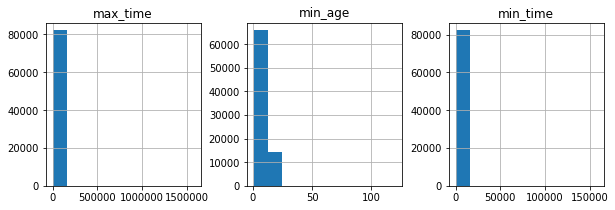

In [671]:
df.hist(column=['min_age','min_time','max_time'], layout=(1,3), figsize=(10,3));

Text(0.5,1,'Maximum Recommended Time')

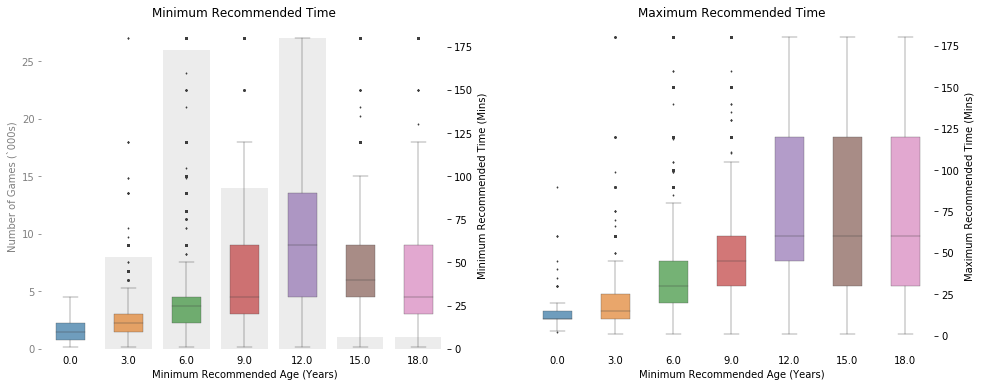

In [848]:
# Cap the time and bucket & cap the age
max_time_cap = df.max_time.quantile(0.95)
# Age capped at 18 and bucketed into bins of 3 width
df['min_age_capped'] = df.min_age.apply(lambda x: np.floor(min(x,18)/3)*3) 
df['max_time_capped'] = df.max_time.apply(lambda x: min(x,max_time_cap))
# We cap the min_time and the *max_time* 0.95 percentile also to make it easier to compare the two
df['min_time_capped'] = df.min_time.apply(lambda x: min(x,max_time_cap)) 

df_counts = df['min_age_capped'].value_counts().sort_index()

# Setup plots
fig,ax = plt.subplots(1,2, figsize=(16,6))
ax_b = ax[0].twinx() # Second y axes for plot 0
ax_c = ax[1].twinx() # Second y axes for plot 1

# Plotting
sns.barplot(x= df_counts.index, y = df_counts.values/1000,  ax = ax[0], color='grey', alpha=0.15)
sns.boxplot(x="min_age_capped", y="min_time_capped", data=df, boxprops=dict(alpha=.7)
                                                    , ax = ax_b, fliersize=1, width = 0.5, linewidth=0.4)
sns.boxplot(x="min_age_capped", y="max_time_capped", data=df, boxprops=dict(alpha=.7)
                                                    , ax = ax_c, fliersize=1, width = 0.5, linewidth=0.4)

# Cleanup
sns.despine(left=True, bottom=True)
ax_b.set_ylim(0,ax_c.get_ylim()[1]) # Set both y1-axes to be equal in scale
ax[1].set_yticks([]) # Remove ax[1] y-axis label
ax[1].set_ylabel('') # Remove ax[1] y-axis
ax_b.set_ylabel('Minimum Recommended Time (Mins)') # Relabel y
ax_c.set_ylabel('Maximum Recommended Time (Mins)') # Relabel y
ax[0].set_xlabel('Minimum Recommended Age (Years)')  # Relabel x
ax[1].set_xlabel('Minimum Recommended Age (Years)') 
ax[0].set_ylabel('Number of Games (`000s)', color='grey') # Relabel y
ax[0].tick_params(axis='y', colors='grey')
ax[0].tick_params(axis='x', bottom='off') # Turn off ticks on x
ax[1].tick_params(axis='x', bottom='off')
#ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f')) # Format tick labels

ax[0].set_title('Minimum Recommended Time')  # Relabel x
ax[1].set_title('Maximum Recommended Time')  # Relabel x
# Label the grey bars for clarity
#ax[0].text(1.4,0.9*max(df_counts),'Number of Games', color='grey', alpha = 0.5, rotation=90);


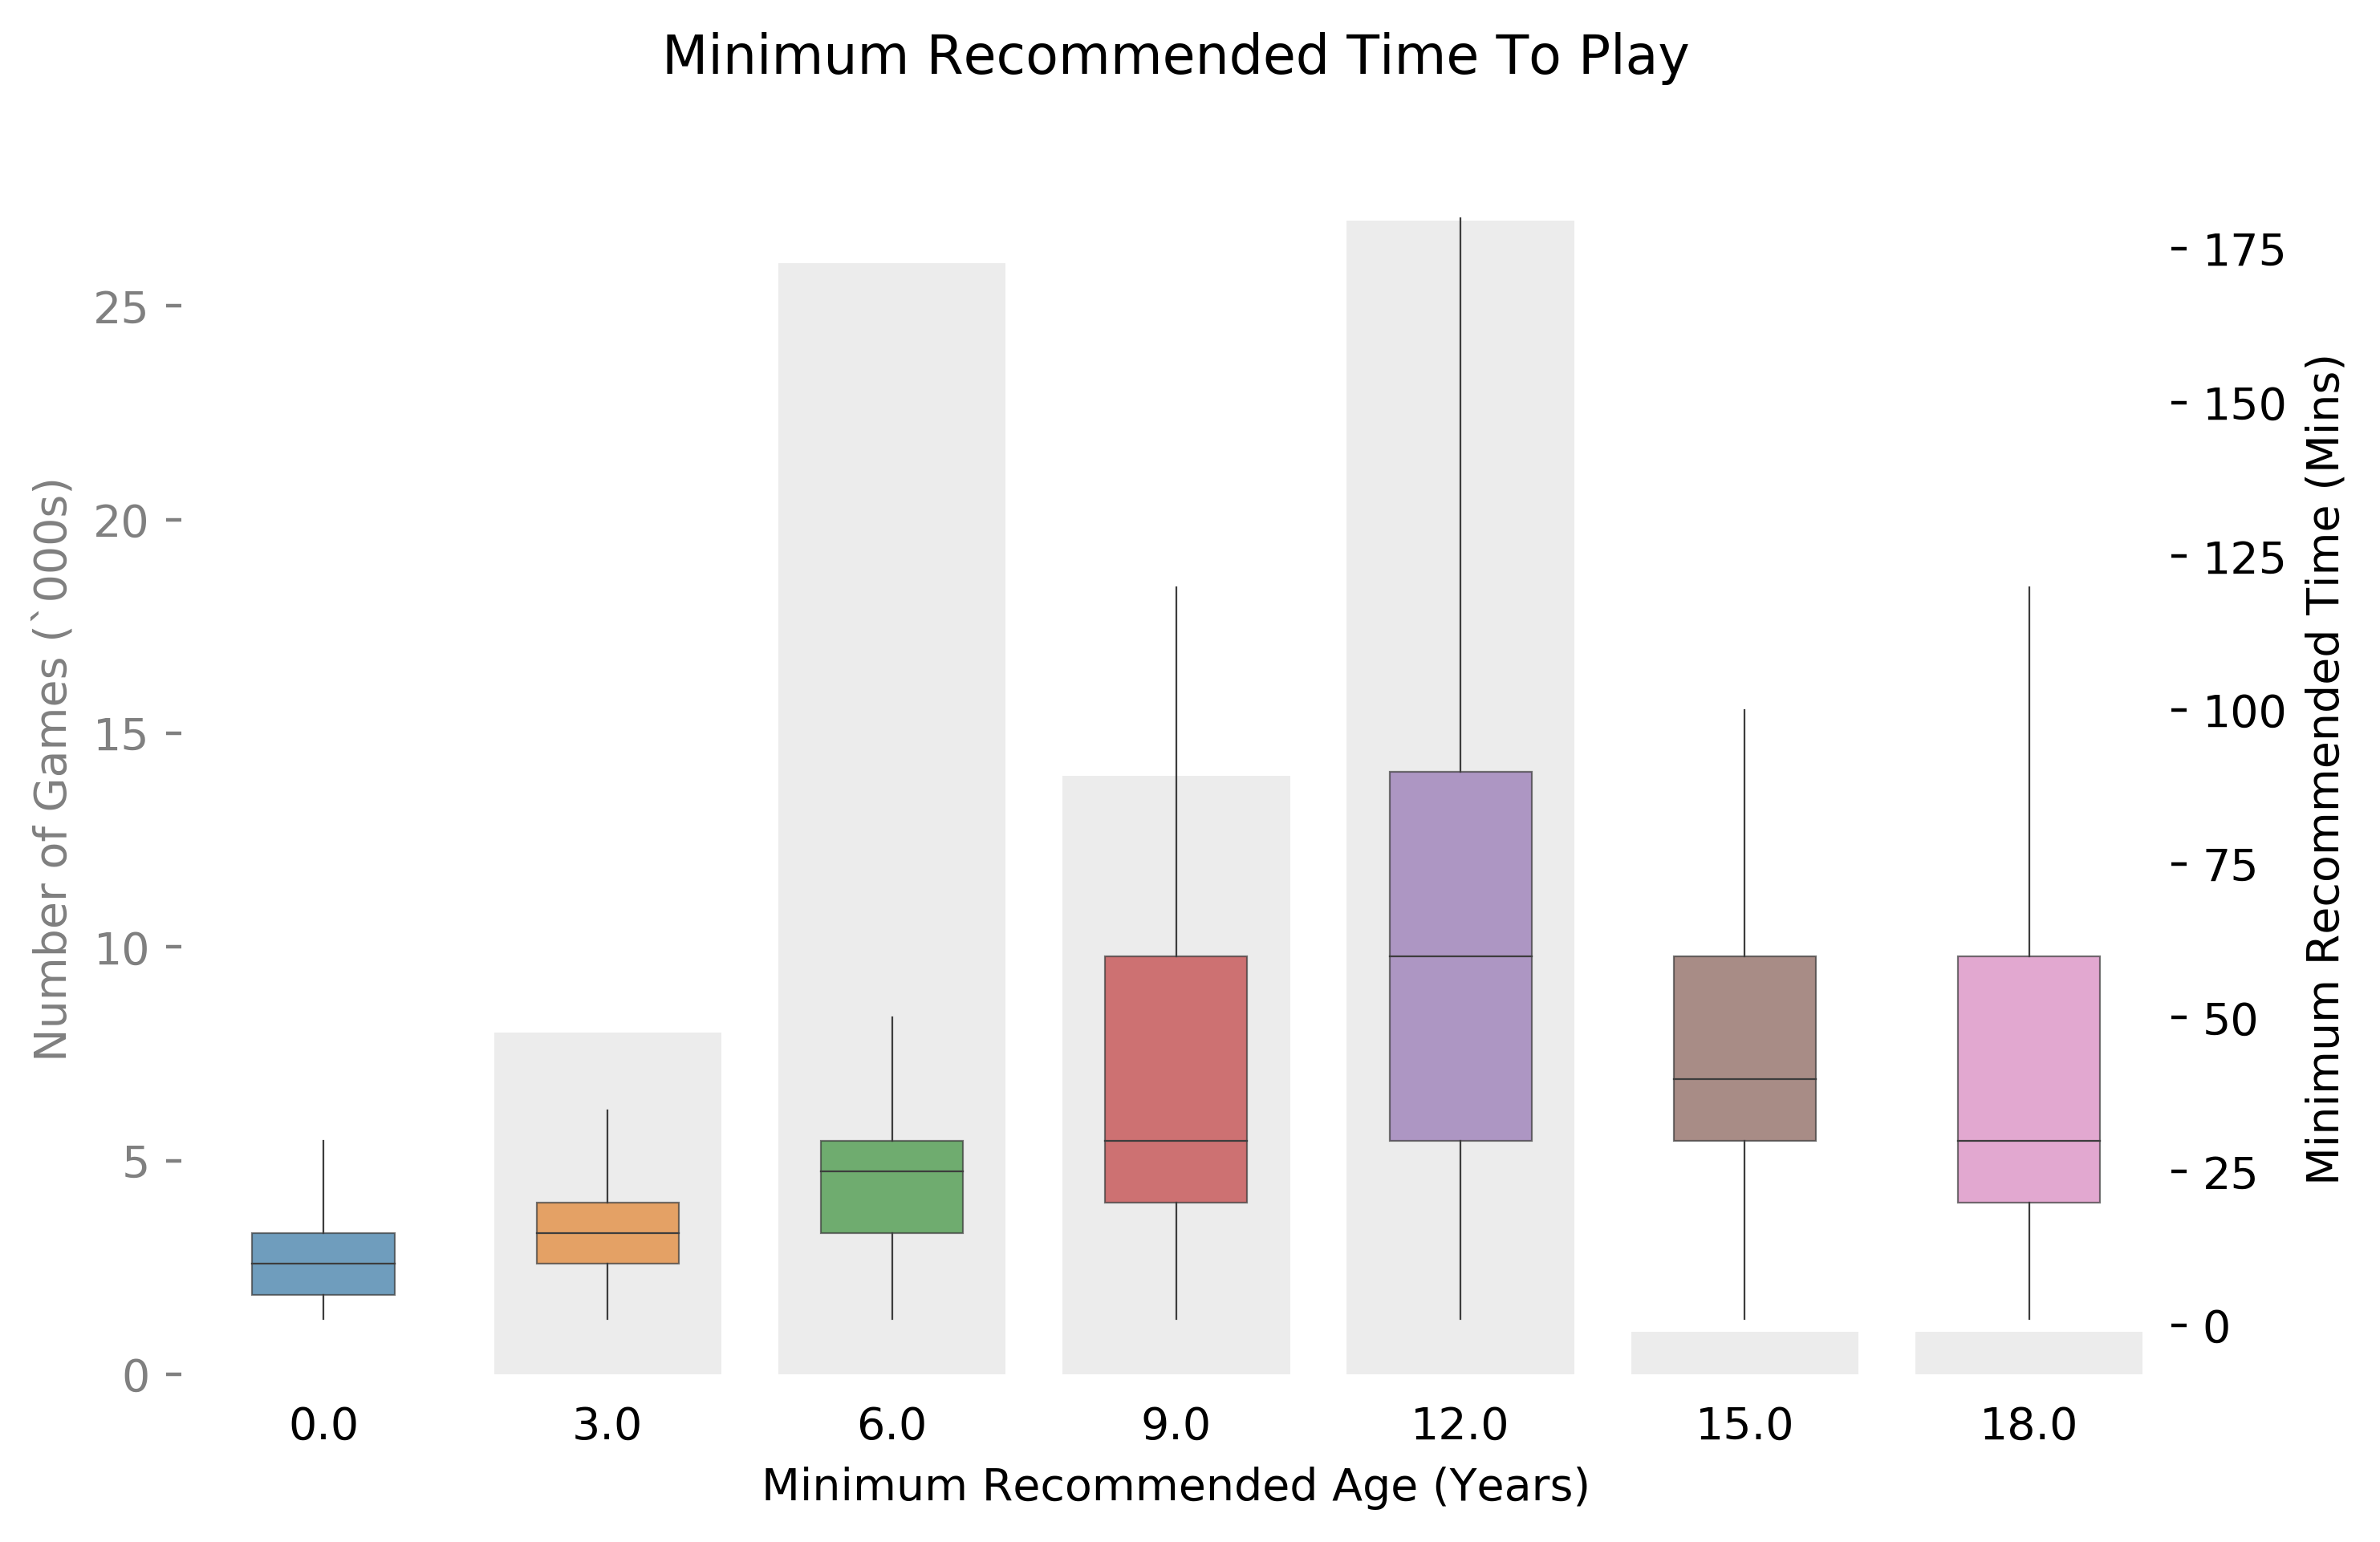

In [865]:

# Setup plots
fig,ax = plt.subplots(1,1, figsize=(8,5), dpi = 400)
ax_b = ax.twinx() # Second y axes for plot 0

# Plotting
sns.barplot(x= df_counts.index, y = df_counts.values/1000,  ax = ax, color='grey', alpha=0.15)
sns.boxplot(x="min_age_capped", y="min_time_capped", data=df, boxprops=dict(alpha=.7)
                                                   , ax = ax_b, fliersize=1, width = 0.5
                                                   , linewidth=0.4, showcaps = False, showfliers=False)


# Cleanup
sns.despine(left=True, bottom=True)
ax_b.set_ylabel('Minimum Recommended Time (Mins)') # Relabel y
ax.set_xlabel('Minimum Recommended Age (Years)')  # Relabel x
ax.set_ylabel('Number of Games (`000s)', color='grey') # Relabel y
ax.tick_params(axis='y', colors='grey')
ax.tick_params(axis='x', bottom='off') # Turn off ticks on x
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) # Format tick labels

ax.set_title('Minimum Recommended Time To Play', pad=20);  # Relabel x
# Label the grey bars for clarity
#ax[0].text(1.4,0.9*max(df_counts),'Number of Games', color='grey', alpha = 0.5, rotation=90);
plt.savefig('saving-a-seaborn-plot-as-eps-file.png')


In the left-hand plot above we also show the number of games in each age-bucket (in grey).  This is identical for the right-hand plot so is omitted.

It appears that the suggested minimum-play-time increases with recommended age, at least up to 12-years.  After this point it appears to decrease again.  We appreciate that there is a smaller sample size for recommended ages older than 12 years, however, it is still in the thousands so we are happy to infer patterns from those ranges.

One reason for this might be that for a game to be rated as either 15+ or 18+, it is likely to be a game of a more adult nature (perhaps an after-dinner game) and so is likely to be designed to be played more quickly that a classic board-game.

# Publishers with Ratings

We now move onto question 2 of the set above, and we must reduce the dataset down to just those games that have a rating.  We also only concern ourselves with publishers that have created >1% of the games in the rated set, so that we are investigating a maneagable number of publishers.

In [708]:
df_rated = df.dropna(subset=['avg_rating'])
print("There are {} games with a rating, out of {} in the dataset".format(df_rated.shape[0], df.shape[0]))

There are 3578 games with a rating, out of 113997 in the dataset


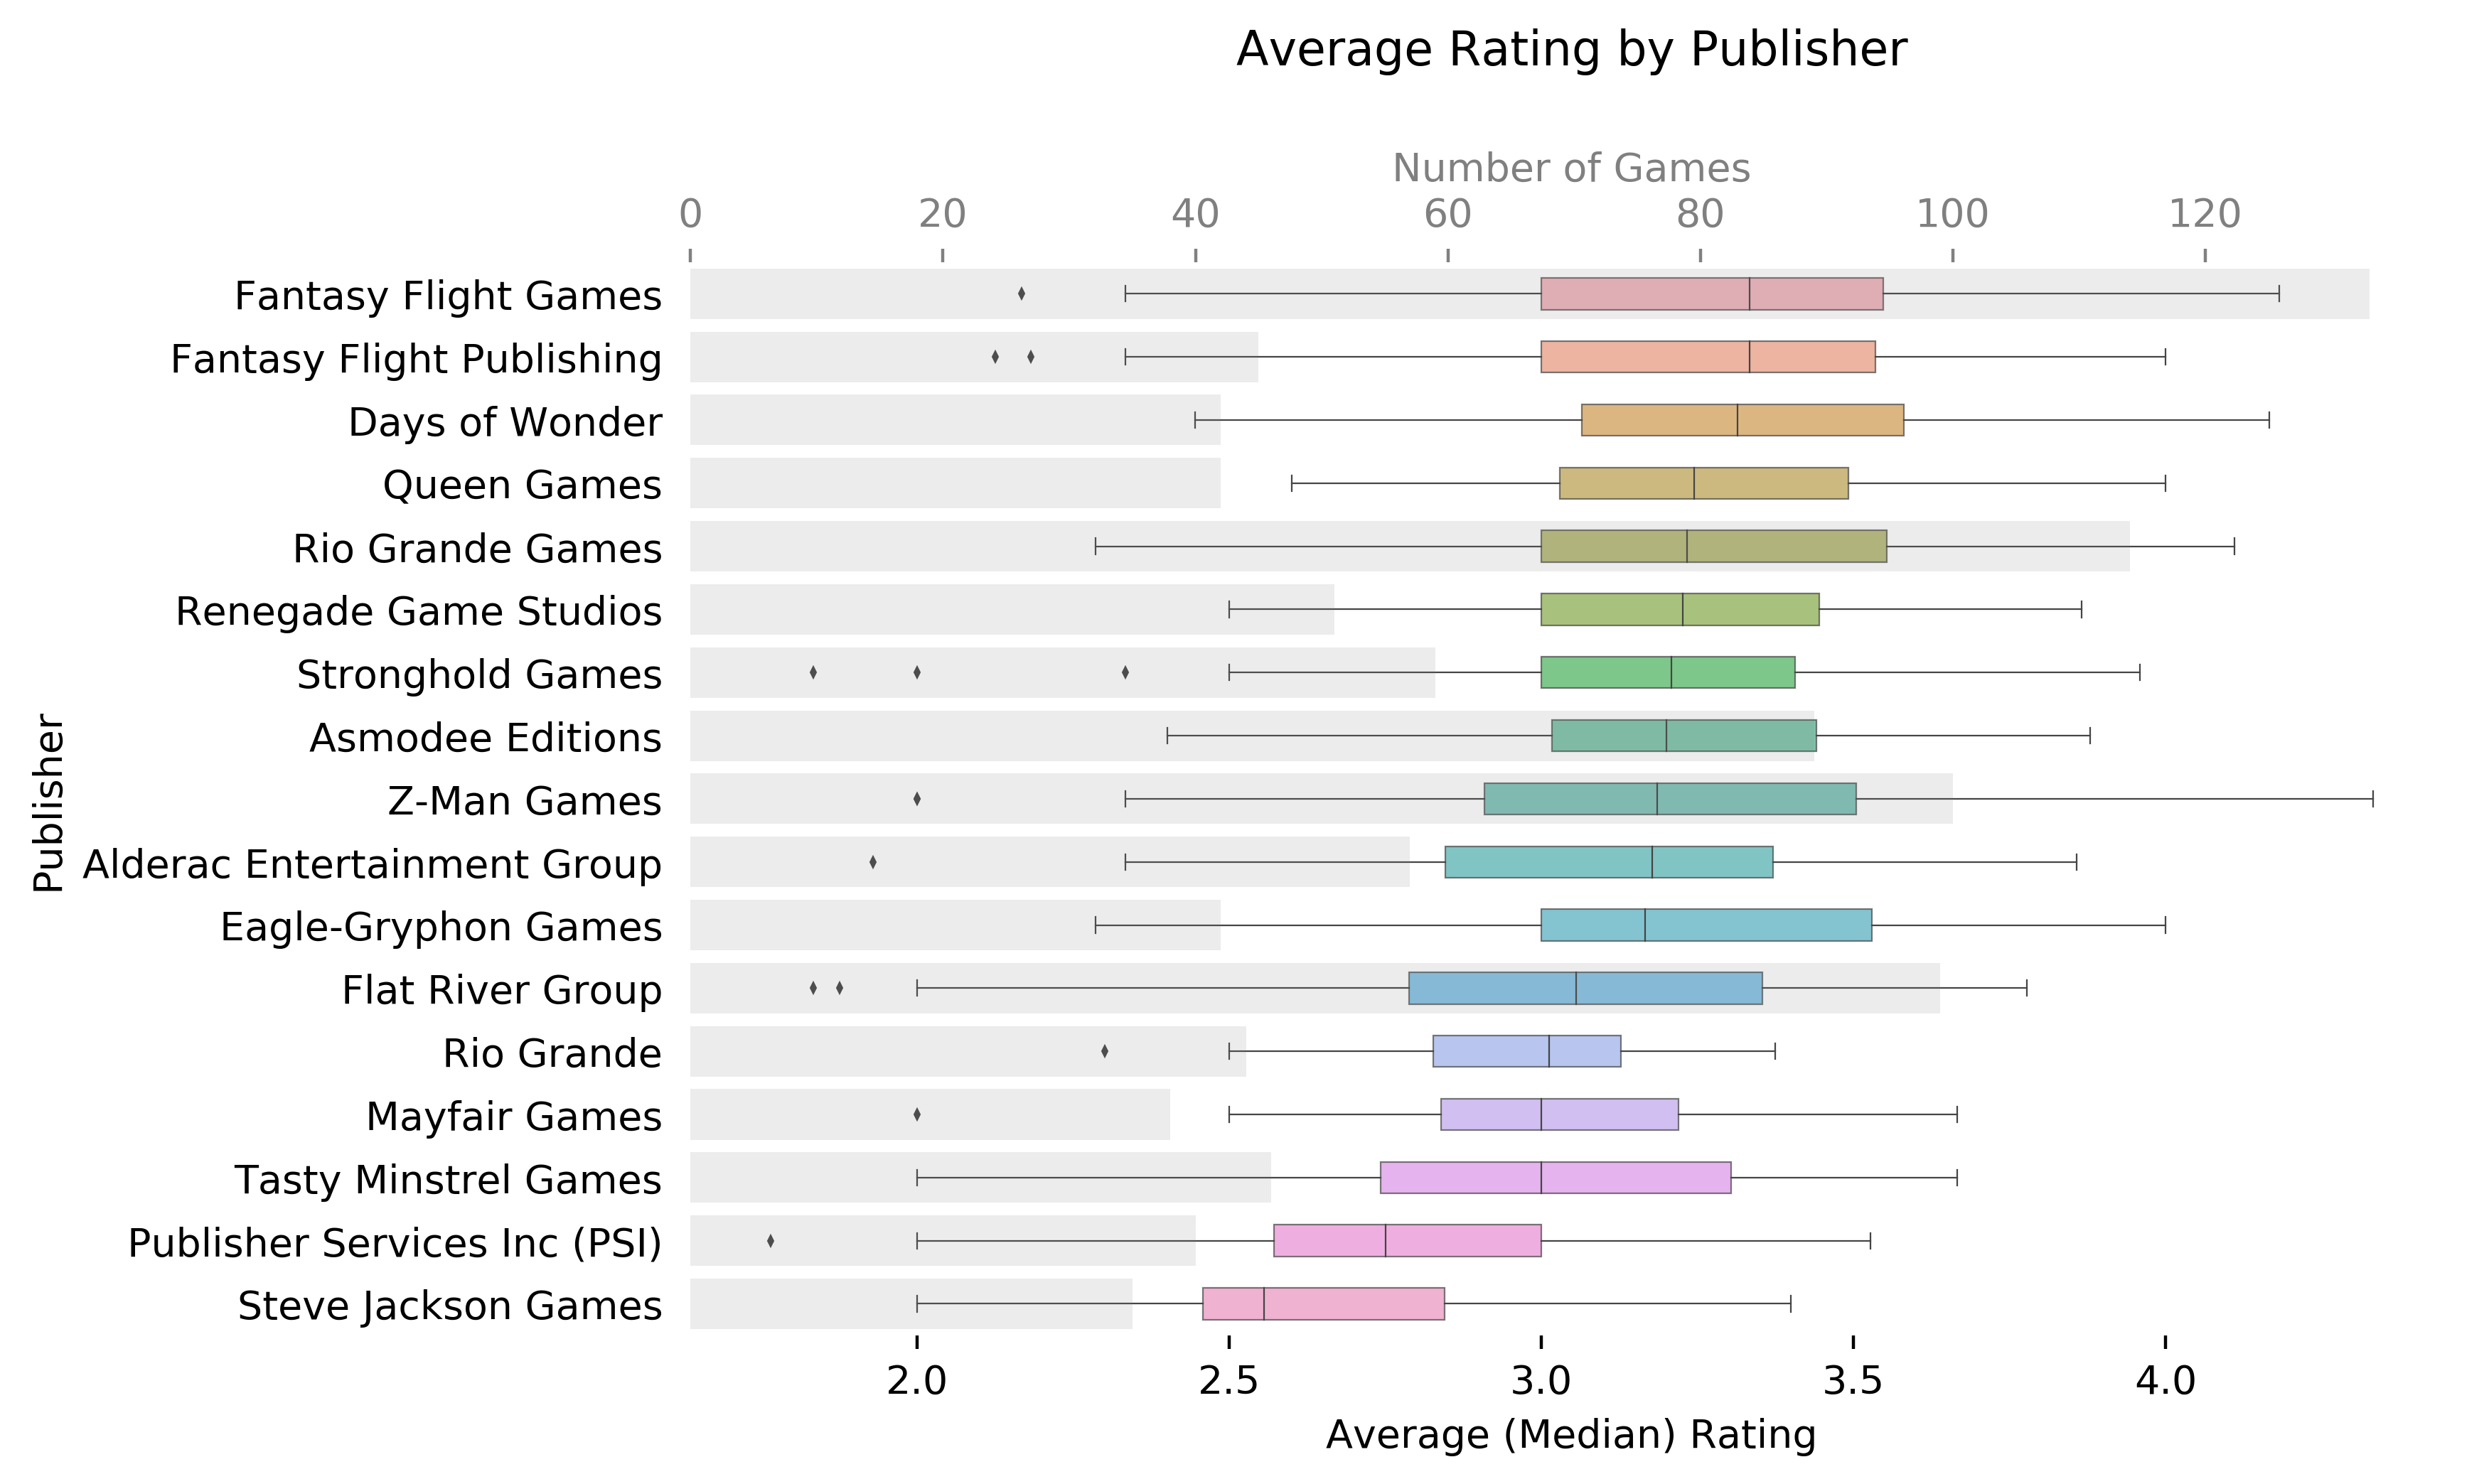

In [868]:
frequent_publisher = df_rated.publisher.value_counts(normalize=True) > 0.01
frequent_publisher = frequent_publisher[frequent_publisher].index.to_list()

df_top_pub_with_rating = df_rated[df_rated.publisher.isin(frequent_publisher)]
df_counts_pub = df_top_pub_with_rating['publisher'].value_counts().sort_index()

publisher_order = df_top_pub_with_rating[['publisher','avg_rating']].groupby('publisher').median()
publisher_order = publisher_order.sort_values(by='avg_rating', ascending=False).index

fig,ax = plt.subplots(1,1,figsize = (8,5), dpi = 400)
ax_b = ax.twiny() # Second y axes for plot 0

sns.barplot(y=df_counts_pub.index, x=df_counts_pub.values, ax = ax_b, color='grey', alpha=0.15, order = publisher_order)
sns.boxplot(y="publisher", x="avg_rating", data=df_top_pub_with_rating,  boxprops=dict(alpha=.7)
                         , ax=ax,fliersize=1, order = publisher_order, width =0.5,linewidth=0.4)

# Cleanup
sns.despine(left=True, bottom=True)

ax.set_xlabel('Average (Median) Rating')  # Relabel x
ax_b.set_xlabel('Number of Games', color='grey')  # Relabel x
ax_b.spines['top'].set_color('grey')            # Recolor secondary axis
ax_b.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', left='off')

ax.set_ylabel('Publisher') # Relabel y
ax.set_title('Average Rating by Publisher',pad=50);  # Relabel x
plt.savefig('publishers_vs_rating.png',bbox_inches='tight')


Considering Steve Jackson Games, the lowest rated of the popular games, we see they have a median rating of ~2.5, compared to the top publishers rating of 3.3.  There is one thing we cannot rule out from this one-dimensional slice of the data however, that is - there may be a hidden variable which negatively affects reviews, and which Steve Jacksons Games are particularly prone to (e.g. a certain Category or Mechanic).

### Now to the model

Before we can being to build a model we need to clean the data...

### Cleaning the data

There are many columns in the data that have blank values

In [51]:
# Remove all columns with no data
df_dropped = df.dropna(how='all', axis=1)

In [87]:
perc_rated = 1-df_dropped.avg_rating.isna().mean()
num_rated = sum(~df_dropped.avg_rating.isna())
print("Only {:.1f}% of games are rated, drop the unrated ones, this leaves us with {} rated games".format(perc_rated*100,num_rated))
df_rated = df_dropped[~df_dropped.avg_rating.isna()]

Only 3.1% of games are rated, drop the unrated ones, this leaves us with 3578 rated games


In [88]:
df_rated.head()

name    year                        designer  \
72                                Poo  2009.0                    Matthew Grau   
165                 Ascending Empires  2011.0                  Ian Cooper (I)   
199  Clank! A Deck-Building Adventure  2012.0                     Paul Dennen   
202        Dominion Big Box (English)  2010.0             Donald X. Vaccarino   
217                         El Grande  1995.0  Wolfgang Kramer,Richard Ulrich   

                                                artist  \
72                        Brett Bean,Mike Vaillancourt   
165                                       Chechu Nieto   
199                Rayph Beisner,Raul Ramos,Nate Storm   
202  Matthias Catrein,Julien Delval,Ryan Laukat,Har...   
217                                     Doris Matthäus   

                        publisher  min_players  max_players  min_age  \
72   Publisher Services Inc (PSI)          2.0          2.0      6.0   
165                   Z-Man Games          2.0          4.0     10.0   
199         Renegade Game Studios          2.0          4.0     13.0   
202              Rio Grande Games          2.0          4.0     12.0   
217                           NaN          2.0          5.0     12.0   

     min_time  max_time               category  \
72       10.0      10.0                    NaN   
165      75.0      75.0                    NaN   
199      30.0      60.0  KUBCKBkGxV,ZTneo8TaIO   
202      30.0      30.0                    NaN   
217      60.0     120.0  QAYkTHK1Dd,nuHYRFmMjU   

                                              mechanic  num_votes  avg_rating  \
72                    WPytek5P8l,BGrhzIN69D,T8JEFYwoqy         17    1.764706   
165                                         lA3KUtVFCy          6    3.333333   
199        vZsDDAdOoe,BGrhzIN69D,MEAoOygZsA,hmipYN1R1I        225    3.571291   
202                                         vZsDDAdOoe          8    3.750000   
217  05zCZoLvQJ,bgGxE0pI2B,AZxlPpi5oq,iWODHwRGuU,WP...         89    3.584270   

         bga_id  
72   02PVTOKqhe  
165  060LSi2szR  
199  07FXm6tX4o  
202  07N2GoxAFA  
217  07sKc1TGJS

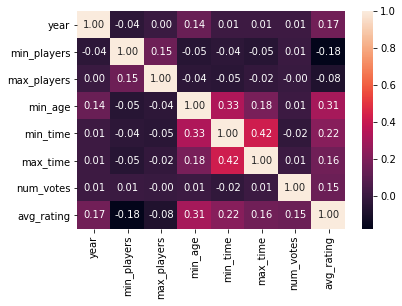

In [205]:
# Check whether the quantitative features have correlation
sns.heatmap(df_rated.corr(),annot=True, fmt = '0.2f')

# Full model

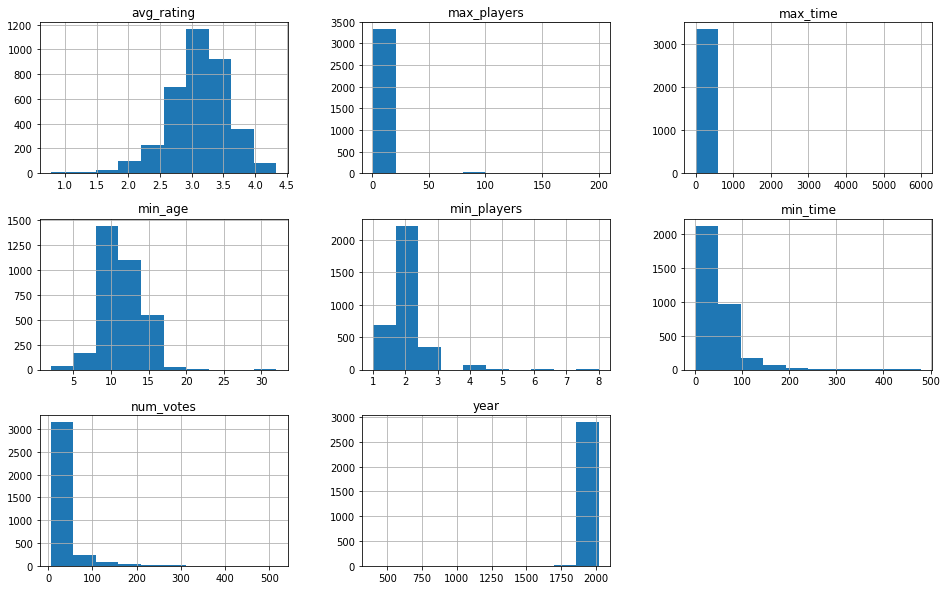

In [206]:
# Explore basic distributions
df_rated.hist(figsize = (16,10));

In [108]:
#Remove outliers
df_rated.isna().mean()
#df_rated['max_players_crop'] = df_rated.apply(lambda x: min(x,10), axis=1)

name           0.000000
year           0.185299
designer       0.198155
artist         0.282840
publisher      0.044718
min_players    0.061487
max_players    0.061487
min_age        0.070989
min_time       0.065400
max_time       0.066797
category       0.741755
mechanic       0.192845
num_votes      0.000000
avg_rating     0.000000
bga_id         0.000000
dtype: float64

In [530]:
df_dropped = df.dropna(how='all', axis=1)
df_dropped_hard = df_dropped.dropna()

In [156]:
df_dropped_hard.shape

(536, 15)

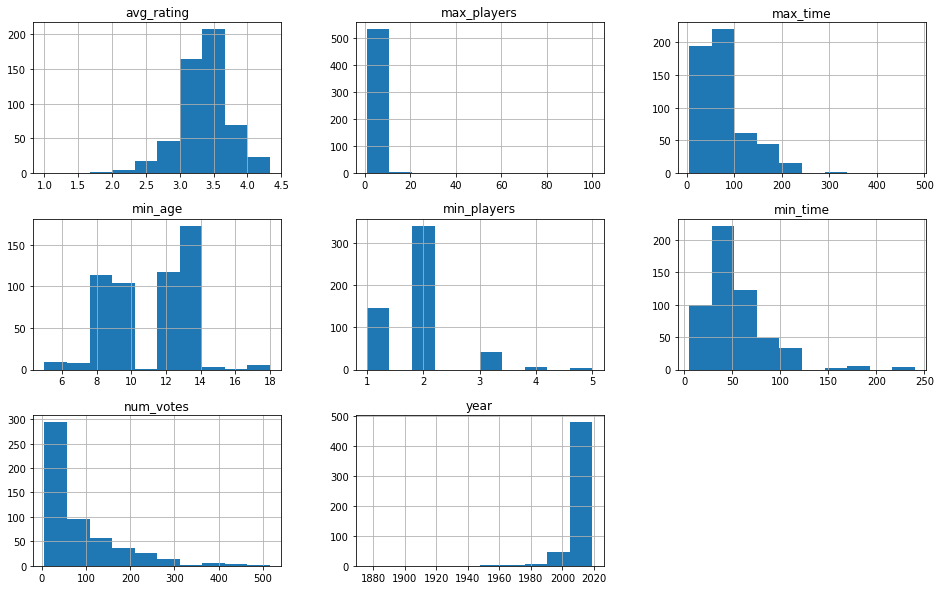

In [157]:
df_dropped_hard.hist(figsize = (16,10));

In [531]:
# Crop outlying data
df_dropped_hard.max_players = df_dropped_hard.max_players.apply(lambda x: min(x,10))
df_dropped_hard.max_time = df_dropped_hard.max_time.apply(lambda x: min(x,200))
df_dropped_hard.min_time = df_dropped_hard.min_time.apply(lambda x: min(x,100))

df_dropped_hard.year = df_dropped_hard.year.apply(lambda x: max(x,1995))

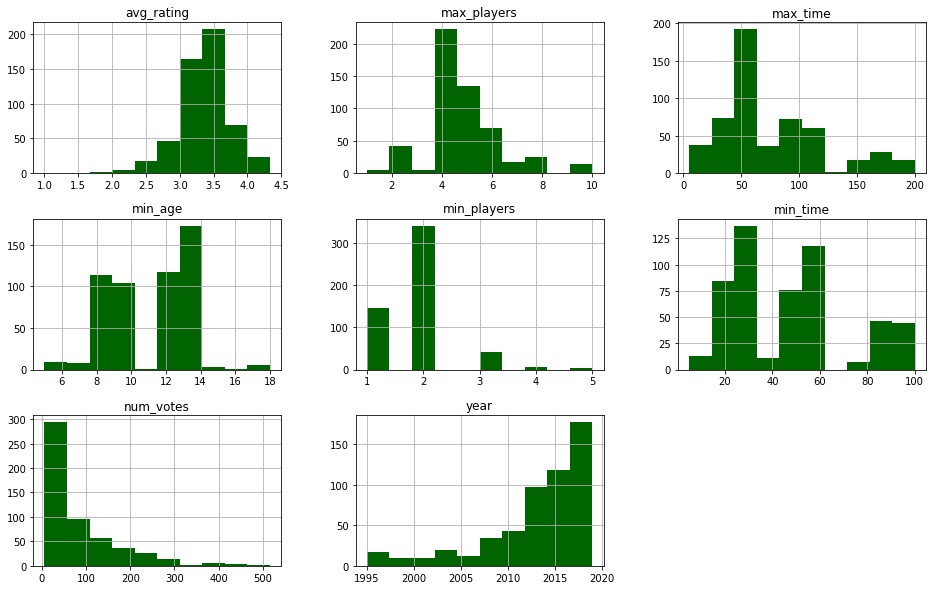

In [166]:
df_dropped_hard.hist(figsize = (16,10), color='darkgreen');

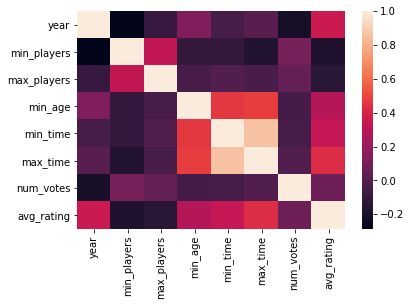

In [167]:
sns.heatmap(df_dropped_hard.corr())

In [545]:
num_cols = df_dropped_hard.select_dtypes(exclude=['object'])
cat_cols = df_dropped_hard.select_dtypes(include=['object'])

print(num_cols.columns.to_list())

#Split into explanatory and response variables
X = num_cols.drop('avg_rating',axis=1) # Drop avg_rating column
y = num_cols['avg_rating']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True, we) # Instantiate
lm_model.fit(X_train, y_train) #Fit

y_pred_test = lm_model.predict(X_test)
y_pred_train = lm_model.predict(X_train)

r2_score(y_test,y_pred_test),r2_score(y_train,y_pred_train)

['year', 'min_players', 'max_players', 'min_age', 'min_time', 'max_time', 'num_votes', 'avg_rating', 'cat_eX8uuNlQkQ', 'cat_ZTneo8TaIO', 'cat_N0TkEGfEsF', 'cat_QAYkTHK1Dd', 'cat_3B3QpKvXD3', 'cat_KUBCKBkGxV', 'cat_upXZ8vNfNO', 'cat_v4SfYtS2Lr', 'cat_ODWOjWAJj3', 'cat_mavSOM8vjH', 'mech_WPytek5P8l', 'mech_R0bGq4cAl4', 'mech_lA3KUtVFCy', 'mech_XM2FYZmBHH', 'mech_iWODHwRGuU', 'mech_8PN2HE86wg', 'mech_05zCZoLvQJ', 'mech_fBOTEBUAmV', 'mech_vZsDDAdOoe', 'mech_U3zhCQH7Et']


(0.31585787213345085, 0.41166852564953516)

In [505]:
# Unpack multiple choice categories and mechanics
# Find top 10 of each

all_categories = df_dropped_hard.category.str.split(',',expand=True).stack().value_counts()
top_10_categories = all_categories[:10].index.to_list()
top_10_categories

all_mechanics = df_dropped_hard.mechanic.str.split(',',expand=True).stack().value_counts()
top_10_mechanics = all_mechanics[:10].index.to_list()
top_10_mechanics[:5]


['WPytek5P8l', 'R0bGq4cAl4', 'lA3KUtVFCy', 'XM2FYZmBHH', 'iWODHwRGuU']

In [541]:
df_dropped_hard.designer.isna().mean()

0.0

In [504]:
cats.loc[top_10_categories].head()

name
id                   
eX8uuNlQkQ  Card Game
ZTneo8TaIO    Fantasy
N0TkEGfEsF   Economic
QAYkTHK1Dd   Medieval
3B3QpKvXD3     Sci-Fi

In [538]:
top_10_cat_dummies_df  = df_dropped_hard.category.str.get_dummies(sep=',')[top_10_categories].add_prefix('cat_')
top_10_mech_dummies_df = df_dropped_hard.mechanic.str.get_dummies(sep=',')[top_10_mechanics].add_prefix('mech_')

In [539]:
df_dropped_hard = pd.concat([df_dropped_hard,top_10_cat_dummies_df,top_10_mech_dummies_df], axis=1)

In [561]:
num_cols = df_dropped_hard.select_dtypes(exclude=['object'])
cat_cols = df_dropped_hard.select_dtypes(include=['object'])

print(num_cols.columns.to_list())

#Split into explanatory and response variables
X = num_cols.drop('avg_rating',axis=1) # Drop avg_rating column
y = num_cols['avg_rating']
w = num_cols['num_votes']  # Sample weight by number of votes for each game

#Split into train and test
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train, sample_weight = np.sqrt(w_train)) #Fit using sqrt of num_votes as a weight

y_pred_test = lm_model.predict(X_test)
y_pred_train = lm_model.predict(X_train)

r2_score(y_test,y_pred_test),r2_score(y_train,y_pred_train)

['year', 'min_players', 'max_players', 'min_age', 'min_time', 'max_time', 'num_votes', 'avg_rating', 'cat_eX8uuNlQkQ', 'cat_ZTneo8TaIO', 'cat_N0TkEGfEsF', 'cat_QAYkTHK1Dd', 'cat_3B3QpKvXD3', 'cat_KUBCKBkGxV', 'cat_upXZ8vNfNO', 'cat_v4SfYtS2Lr', 'cat_ODWOjWAJj3', 'cat_mavSOM8vjH', 'mech_WPytek5P8l', 'mech_R0bGq4cAl4', 'mech_lA3KUtVFCy', 'mech_XM2FYZmBHH', 'mech_iWODHwRGuU', 'mech_8PN2HE86wg', 'mech_05zCZoLvQJ', 'mech_fBOTEBUAmV', 'mech_vZsDDAdOoe', 'mech_U3zhCQH7Et']


(0.3213295387810349, 0.40319084365958335)

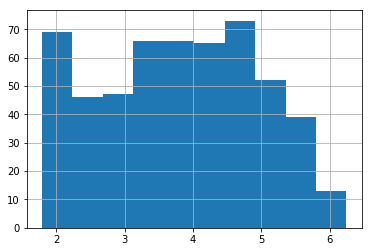

In [558]:
np.log(df_dropped_hard.num_votes).hist()

TODO:
    
    Fill NaNs
    Weight by votes?
    Clean Game publishers (e.g. Fantasy Flight Games and Fantasy Flight Publishing?)
    

# Scratch

In [698]:
# Scratch attempt at plotly plot

px.box(df,y="min_time_capped", x="min_age_capped", notched=True, points='all')